# HCMUS-UNIV-WebScience-VisualizeData

## PROJECT 2: MỐI QUAN HỆ CỦA DỮ LIỆU


### I. Chuẩn bị môi trường:

In [260]:
import sqlite3
import pandas as pd
import numpy as np
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def fetch_value(sqlCommand):
    conn = sqlite3.connect("data.db",check_same_thread=False)
    ret = pd.read_sql_query(sqlCommand, conn)
    conn.close()
    return ret

# Query dữ liệu
def query_sql(sql:str):
    listData = fetch_value(sql)
    return listData

# Lấy bài viết theo website.
def get_bai_viet(website:str):
    return query_sql(f"select * from baiviet where website='{website}'")

class Utils:
    def convertHMtoFloat(HM):
        dv = str(HM).split(":")
        if len(dv) > 1:
            h,m = dv
        else:
            h,m = dv[0],0
        return int(h)+(float(m)/60)

### I. Tiền xử lý dữ liệu

 #### Yêu cầu: đưa các field về dạng chuẩn chung:

1. active_time: thời gian hoạt động, đưa về dạng sau:

```
    {
        <tên ngày trong tuần>:[ <thời gian mở cửa>,<thời gian đóng cửa> ]
    }

    *lowercase
    *thời gian đưa về float: 8h30 => 8.5
```
    
- ví dụ:

```
    {
        "thứ 2": [7,21.5],
        ...,
        "chủ nhật": [8,22.3]
    }
```

2. other_service: các dịch vụ khác, đưa về dạng sau:

```
    [
        <tên dịch vụ>,
        <tên dịch vụ>,
        ...,
    ]
    
    *lowercase
```
    
- ví dụ:

```
    [
        "có wifi"
        "giao hàng",
        ...,
    ]
```

#### I.1 Foody

In [4]:
def preprocessing_Foody():
    # Code here
    data = get_bai_viet("Foody")
    active_time = data["active_time"]
    other_service = data["other_service"]
    format_time = []
    format_other = []
    for time in active_time:
        #time = time.open + ',' + time.close
        time = json.loads(time)
        time_format = []
        time_format.append(Utils.convertHMtoFloat(time['open']))
        time_format.append(Utils.convertHMtoFloat(time['close']))
        x = {
            "thứ 2":time_format,
            "thứ 3":time_format,
            "thứ 4":time_format,
            "thứ 5":time_format,
            "thứ 6":time_format,
            "thứ 7":time_format,
            "chủ nhật":time_format,
        }
        format_time.append(x)
    data['active_time'] = format_time
    for other in other_service:
        otherjs = json.loads(other)
        format_other.append([x.lower() for x in otherjs])
    data['other_service'] = format_other

    def reformat_district_map(district):
        return district.replace("huyện ","").replace("thành phố ","")
    data['district'] = data['district'].apply(reformat_district_map)

    return data

#### I.2 ShopeeFood

In [5]:
def preprocessing_ShopeeFood():
    def maping(name):
        if name=="monday":
            return "thứ 2"
        if name=="tuesday":
            return "thứ 3"
        if name=="wednesday":
            return "thứ 4"
        if name=="thursday":
            return "thứ 5"
        if name=="friday":
            return "thứ 6"
        if name=="saturday":
            return "thứ 7"
        if name=="sunday":
            return "chủ nhật"

    def convert_active_time(HM):
        pre_format = {}
        at_js = json.loads(HM)
        atl = list(at_js)
        for key in atl:
            open,close = at_js[key].split("-")
            pre_format[maping(key)] = [Utils.convertHMtoFloat(open),Utils.convertHMtoFloat(close)]
        return pre_format

    data = get_bai_viet("ShopeeFood")
    data["active_time"] = data["active_time"].apply(convert_active_time)

    return data

#### I.3 GoogleReview

In [6]:
def preprocessing_GoogleReview():
    def reformat_district_map(district):
        return district.replace("thành phố ","")
    
    BlackDistrict=[
        '2 hải triều',
        'vn  1 45 lý tự trọng bến nghé',
        'district 1',
        'thảo điền  2 hồ chí minh',
        'district 02',
        'phường 10  4 hồ chí minh',
        '06',
        '05',
        '19a đường 182 lã xuân oai tăng nhơn phú a',
        'số 01 đường 48 kdc bảo châu phường 16  08 tp',
        'tp',
        '30 cửu long phường 15  10  10',
        '479/55 tân thới hiệp 07',
    ]

    def maping(name):
        if name=="Thứ Hai":
            return "thứ 2"
        if name=="Thứ Ba":
            return "thứ 3"
        if name=="Thứ Tư":
            return "thứ 4"
        if name=="Thứ Năm":
            return "thứ 5"
        if name=="Thứ Sáu":
            return "thứ 6"
        if name=="Thứ Bảy":
            return "thứ 7"
        if name=="Chủ Nhật":
            return "chủ nhật"

    def convert_active_time(HM):
        pre_format = {}
        at_js = json.loads(HM)
        atl = list(at_js)
        for key in atl:
            if (key == "open"):
                pre_format = {
                    "thứ 2":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 3":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 4":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 5":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 6":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "thứ 7":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    "chủ nhật":[Utils.convertHMtoFloat("00:00"),Utils.convertHMtoFloat("23:59")],
                    }
            if (at_js[key] == "Mở cửa cả ngày" or at_js[key] == "Đóng cửa"):
                open = "00:00"
                close = "23:59"
            else :
                time_format = at_js[key].split("–")
                open = time_format[0]
                close = time_format[len(time_format) - 1]
            
            pre_format[maping(key)] = [Utils.convertHMtoFloat(open),Utils.convertHMtoFloat(close)]
        return pre_format

    data = get_bai_viet("GoogleReview")
    data["active_time"] = data["active_time"].apply(convert_active_time)
    
    def convert_other_service(strjson):
        strjson = json.loads(strjson.replace('\\u00a0',''))
        return [x.lower() for x in strjson]
    data['other_service'] = data['other_service'].apply(convert_other_service)

    data['district'] = data['district'].apply(reformat_district_map)

    data = data[ ~(data['district'].isin(BlackDistrict)) ]

    return data

#### I.4 Tổng hợp lại dữ liệu tiền xử lý

- Thực hiện kết hợp
- Phân rã dữ liệu thành dạng phẳng

In [7]:
def reformat(filename):
    DATA = pd.concat([preprocessing_Foody(),preprocessing_ShopeeFood(),preprocessing_GoogleReview()],ignore_index=True)

    # Chuyển complex type sang dạng giản đơn
    # active_time => thứ 2 on/off,...
    maping = {
        "thứ 2":"monday",
        "thứ 3":"tuesday",
        "thứ 4":"wednesday",
        "thứ 5":"thursday",
        "thứ 6":"friday",
        "thứ 7":"saturday",
        "chủ nhật":"sunday",
    }

    for index, row in DATA['active_time'].items():
        for weekday in maping.keys():
            open,close = None,None
            if row.get(weekday):
                open,close = row[weekday]
            DATA.loc[index,maping[weekday]+'_open'] = open
            DATA.loc[index,maping[weekday]+'_close'] = close

    # liệt kê ra toàn bộ other_service
    other_services = set()
    for _, row in DATA['other_service'].items():
        if row:
            other_services = set.union(other_services, row)
    other_services = sorted(other_services)

    for index, row in DATA['other_service'].items():
        for kw in other_services:
            value = False
            if row and kw in row:
                value = True
            DATA.loc[index,'s_'+kw] = value
    DATA.to_csv(filename,index=False)
    return DATA

In [8]:
if os.path.exists('data_reformat.csv'):
    DATA = pd.read_csv('data_reformat.csv')
else:
    DATA = reformat('data_reformat.csv')

# Lấy ra các dịch vụ
SERVICES = []

cols = list(DATA.columns)
for col in cols:
    if col.startswith('s_'):
        SERVICES.append(col[2:])

### 2. Thống kê dữ liệu

BIẾN: 

- DATA: `dataframe` chứa toàn bộ dữ liệu
- SERVICES: `list` các dịch vụ

DANH SÁCH CÁC DỊCH VỤ:

In [9]:
for id, v in enumerate(SERVICES):
    if id % 5 == 0:
        print()
    print(repr(v),end='\t')
print("\n\n")
print("Có tổng cộng: %d dịch vụ" % len(SERVICES))


'cho mua về'	'có bàn ngoài trời'	'có chiếu bóng đá'	'có chỗ chơi cho trẻ em'	'có chỗ đậu ôtô'	
'có giao hàng'	'có giao hàng\n:\n> 100k & quận 1'	'có hồ bơi'	'có hỗ trợ hội thảo'	'có hỗ trợ người khuyết tật'	
'có karaoke'	'có khu vực hút thuốc'	'có lò sưởi'	'có máy lạnh & điều hòa'	'có nhạc sống'	
'có phòng riêng'	'có thẻ thành viên'	'có thẻ thành viên\n:\ncó bán vouchers'	'có wifi'	'có xuất hóa đơn đỏ'	
'có xuất hóa đơn đỏ\n:\nthẻ giảm giá'	'dịch vụ tại chỗ'	'giao hàng'	'giao hàng gián tiếp'	'giữ xe máy miễn phí'	
'giữ xe máy miễn phí\n:\n2 tiếng'	'không có đồ ăn mang đi'	'không giao hàng'	'không ăn tại chỗ'	'mua hàng ngay trên xe'	
'mua sắm tại cửa hàng'	'nhà hàng'	'nhận hàng ở lề đường'	'nhận tại cửa hàng'	'nên đặt trước'	
'nên đặt trước\n:\nbắt buộc'	'phòng gym'	'spa & massage'	'sân tennis'	'tip cho nhân viên'	
'trả bằng thẻ'	'trả bằng thẻ\n:\nvisa/master'	'ăn tại chỗ'	'đặt lịch hẹn trực tuyến'	'đồ ăn mang đi'	
'đồ ăn tận phòng'	


Có tổng cộng: 46 dịch vụ


#### Thống kê trên toàn bộ dữ liệu
- Các field: rate, rate_count, price_from, price_to

In [10]:
#Summary statistic

DATA.describe()

,rate,rate_count,favorite,price_from,price_to,monday_open,monday_close,tuesday_open,tuesday_close,wednesday_open,wednesday_close,thursday_open,thursday_close,friday_open,friday_close,saturday_open,saturday_close,sunday_open,sunday_close
count,5801.000000,5801.000000,3927.000000,5.801000e+03,5.801000e+03,5783.000000,5783.000000,5787.000000,5787.000000,5787.000000,5787.000000,5785.000000,5785.000000,5786.000000,5786.000000,5783.000000,5783.000000,5761.000000,5761.000000
mean,5.819203,62.664388,41.939649,5.825490e+04,4.733293e+05,8.453139,20.179587,8.464677,20.185260,8.474662,20.175917,8.474898,20.177148,8.468839,20.172834,8.438723,20.182227,8.405164,20.201892
std,3.676943,153.641717,163.079957,1.455547e+05,2.248216e+06,4.418259,5.221462,4.414098,5.207387,4.411955,5.215470,4.410622,5.215819,4.412386,5.225363,4.436966,5.233537,4.475502,5.247239
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,6.500000,20.000000,7.000000,20.000000,7.000000,20.000000,7.000000,20.000000,7.000000,20.000000,6.500000,20.000000,6.500000,20.000000
50%,7.586000,3.000000,2.000000,2.000000e+04,1.000000e+05,9.000000,22.000000,9.000000,22.000000,9.000000,22.000000,9.000000,22.000000,9.000000,22.000000,9.000000,22.000000,9.000000,22.000000
75%,8.600000,32.000000,17.000000,5.500000e+04,3.000000e+05,10.000000,23.000000,10.000000,23.000000,10.000000,23.000000,10.000000,23.000000,10.000000,23.000000,10.000000,23.000000,10.000000,23.000000
max,10.000000,1000.000000,4746.000000,4.000000e+06,1.000000e+08,22.000000,23.983333,22.000000,23.983333,22.000000,23.983333,22.000000,23.983333,22.000000,23.983333,22.000000,23.983333,22.000000,23.983333


#### Thống kê theo điều kiện 1

In [11]:
# Số lượng từng website
DATA.groupby(['website'])['website'].count()

website
Foody           3027
GoogleReview    1874
ShopeeFood       900
Name: website, dtype: int64

- Tiêu chí rate, rate_count, price_from, price_to

In [12]:
colList = ['rate', 'rate_count', 'price_from', 'price_to']

In [13]:
# Thống kê theo từng website
print(DATA[DATA['website']=='Foody'][colList].describe())
print()
print(DATA[DATA['website']=='GoogleReview'][colList].describe())
print()
print(DATA[DATA['website']=='ShopeeFood'][colList].describe())

              rate   rate_count    price_from      price_to
count  3027.000000  3027.000000  3.027000e+03  3.027000e+03
mean      4.785596    12.270895  6.715101e+04  3.017703e+05
std       3.739141    36.984187  1.785913e+05  9.131174e+05
min       0.000000     0.000000  0.000000e+00  0.000000e+00
25%       0.000000     0.000000  1.000000e+04  3.000000e+04
50%       6.680000     1.000000  2.500000e+04  1.200000e+05
75%       7.917000     7.000000  5.000000e+04  2.990000e+05
max      10.000000   584.000000  4.000000e+06  2.700000e+07

              rate   rate_count     price_from        price_to
count  1874.000000  1874.000000    1874.000000     1874.000000
mean      7.832764   145.714043   40661.686233   107310.565635
std       1.563947   222.345001   91033.044666   203085.969412
min       2.000000     0.000000       0.000000        0.000000
25%       7.600000     2.000000       0.000000        0.000000
50%       8.200000    26.000000       0.000000        0.000000
75%       8.800000

In [14]:
# Thống kê theo từng quận
districtList = sorted(DATA['district'].drop_duplicates().tolist())
for distr in districtList:
    print("Thống kê theo quận %s"%distr)
    print()
    print(DATA[DATA['district']==distr][colList].describe())
    print()

Thống kê theo quận 1

             rate   rate_count    price_from      price_to
count  904.000000   904.000000  9.040000e+02  9.040000e+02
mean     6.048867    73.729532  1.040498e+05  7.267737e+05
std      3.466038   170.237410  1.907290e+05  2.020570e+06
min      0.000000     0.000000  0.000000e+00  0.000000e+00
25%      5.000000     0.000000  2.000000e+04  8.900000e+04
50%      7.600000     5.000000  5.000000e+04  3.000000e+05
75%      8.400000    43.250000  1.000000e+05  5.122500e+05
max     10.000000  1000.000000  4.000000e+06  2.800000e+07

Thống kê theo quận 10

             rate   rate_count     price_from      price_to
count  393.000000   393.000000     393.000000  3.930000e+02
mean     6.355354   105.631837   45243.002545  5.112830e+05
std      3.471307   205.718532   72875.663669  3.289135e+06
min      0.000000     0.000000       0.000000  0.000000e+00
25%      5.000000     0.000000       0.000000  0.000000e+00
50%      7.800000    10.000000   20000.000000  5.500000e+04
75%

In [15]:
# Thống kê theo rate
tmp = ['rate_count', 'price_from', 'price_to']

print("Thống kê những nhà hàng tốt rate > 8 sao")
print(DATA[DATA['rate']>8][tmp].describe())
print()
print("Thống kê những nhà hàng thông thường rate = 5 sao")
print(DATA[DATA['rate']==5][tmp].describe())
print()
print("Thống kê những nhà hàng tệ rate < 3 sao")
print(DATA[DATA['rate']<3][tmp].describe())

Thống kê những nhà hàng tốt rate > 8 sao
        rate_count    price_from      price_to
count  2209.000000  2.209000e+03  2.209000e+03
mean    109.500197  5.858967e+04  3.409351e+05
std     198.811602  1.634651e+05  7.865392e+05
min       1.000000  0.000000e+00  0.000000e+00
25%       3.000000  0.000000e+00  0.000000e+00
50%      12.000000  2.000000e+04  1.000000e+05
75%     100.000000  7.000000e+04  3.000000e+05
max    1000.000000  4.000000e+06  1.000000e+07

Thống kê những nhà hàng thông thường rate = 5 sao
       rate_count    price_from       price_to
count  322.000000    322.000000     322.000000
mean     0.130435   1785.714286   11552.795031
std      0.468715   7170.425216   47732.823483
min      0.000000      0.000000       0.000000
25%      0.000000      0.000000       0.000000
50%      0.000000      0.000000       0.000000
75%      0.000000      0.000000       0.000000
max      4.000000  50000.000000  300000.000000

Thống kê những nhà hàng tệ rate < 3 sao
        rate_count   

In [16]:
# Thống kê theo ngày

print("Thống kê những nhà hàng mở cửa cả tuần")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open", "saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[~df1[col].isna()]
print(df1[colList].describe())
print()

print("Thống kê những nhà hàng chỉ mở cửa từ thứ 2 tới thứ 6")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open"]
con2 = ["saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[~df1[col].isna()]
for col in con2:
    df1=df1[df1[col].isna()]
print(df1[colList].describe())
print()

print("Thống kê những nhà hàng chỉ mở cửa từ thứ 7 tới chủ nhật")
con1 = ["monday_open", "tuesday_open", "wednesday_open", "thursday_open", "friday_open"]
con2 = ["saturday_open", "sunday_open"]
df1=DATA
for col in con1:
    df1=df1[df1[col].isna()]
for col in con2:
    df1=df1[~df1[col].isna()]
print(df1[colList].describe())
print()
print(DATA[~df1][colList].describe())

Thống kê những nhà hàng mở cửa cả tuần
              rate   rate_count    price_from      price_to
count  5756.000000  5756.000000  5.756000e+03  5.756000e+03
mean      5.819353    62.795712  5.825585e+04  4.649154e+05
std       3.667377   153.958390  1.459509e+05  2.239897e+06
min       0.000000     0.000000  0.000000e+00  0.000000e+00
25%       0.000000     0.000000  0.000000e+00  0.000000e+00
50%       7.573000     3.000000  2.000000e+04  1.000000e+05
75%       8.600000    32.000000  5.500000e+04  3.000000e+05
max      10.000000  1000.000000  4.000000e+06  1.000000e+08

Thống kê những nhà hàng chỉ mở cửa từ thứ 2 tới thứ 6
            rate  rate_count     price_from      price_to
count   3.000000    3.000000       3.000000  3.000000e+00
mean    6.666667    4.333333   45000.000000  2.550000e+06
std     5.773503    3.785939   47696.960071  3.447100e+06
min     0.000000    0.000000   15000.000000  1.500000e+05
25%     5.000000    3.000000   17500.000000  5.750000e+05
50%    10.000000  

In [17]:
# Thống kê theo dịch vụ

print("Thống kê những nhà hàng có từ 7 dịch vụ trở lên")
def filterbyservice(row):
    c=0
    for ser in SERVICES:
        if row["s_"+ser]:
            c+=1
            if c == 7:
                return True
    return False
df1 = DATA.apply(filterbyservice,axis=1)
print(DATA[df1][colList].describe())
print()

print("Thống kê những nhà hàng không có dịch vụ nào")
def filterbyservice(row):
    c=0
    for ser in SERVICES:
        if row["s_"+ser]:
            return False
    return True
df1 = DATA.apply(filterbyservice,axis=1)
print(DATA[df1][colList].describe())

Thống kê những nhà hàng có từ 7 dịch vụ trở lên
             rate  rate_count    price_from      price_to
count  326.000000  326.000000  3.260000e+02  3.260000e+02
mean     5.031595   35.527607  1.126197e+05  6.850231e+05
std      3.724084   72.463535  1.756933e+05  1.860264e+06
min      0.000000    0.000000  0.000000e+00  0.000000e+00
25%      0.000000    0.000000  1.000000e+04  4.000000e+04
50%      7.195000    4.000000  5.000000e+04  2.825000e+05
75%      7.950000   38.000000  1.490000e+05  5.500000e+05
max     10.000000  584.000000  1.300000e+06  2.700000e+07

Thống kê những nhà hàng không có dịch vụ nào
              rate   rate_count    price_from      price_to
count  1769.000000  1769.000000  1.769000e+03  1.769000e+03
mean      5.428956    49.916025  5.209078e+04  1.012423e+06
std       4.087046   143.587444  1.062456e+05  3.840888e+06
min       0.000000     0.000000  0.000000e+00  0.000000e+00
25%       0.000000     0.000000  1.000000e+04  8.000000e+04
50%       7.200000     2

#### Thống kê theo điều kiện 2

In [221]:
# Code here
DATA.sort_values(by="rate", ascending=False).head()
#Những quán ăn Quận 1 mà được lượt rate cao tới thấp
DATA[DATA["district"].apply(lambda state: state[0] == "1")].sort_values(by="rate", ascending=False).head()

#Những quán có rate cao là số favorite cũng cao
columns_to_show = ["rate", "favorite", "district"]
DATA.sort_values(by="rate", ascending=False).groupby(["full_name"])[columns_to_show].describe(percentiles=[])

#Những quán có giá đắt
columns_show = ["full_name","price_from","price_to",]
DATA.sort_values(by="price_from",ascending=False).groupby(["full_name"])[columns_show].describe(percentiles=[])

price_from                          \
                                                count      mean std       min   
full_name                                                                       
 Lẩu Bò Q7 - La Thành                             1.0       0.0 NaN       0.0   
 MIFASHOP - Mỹ Phẩm, Nước Hoa Chính Hãng          1.0  100000.0 NaN  100000.0   
 Sly1994                                          1.0  100000.0 NaN  100000.0   
 Sơn Mập Quán - Heo Mẹt - Đường Số 11             1.0   50000.0 NaN   50000.0   
1 Food Drink                                      1.0   50000.0 NaN   50000.0   
...                                               ...       ...  ..       ...   
Ốc Đẹp                                            1.0   20000.0 NaN   20000.0   
Ớt Xanh 1 - Cháo Ếch Singapore                    1.0   20000.0 NaN   20000.0   
Ụt Ụt Quán - Barbecue & Beer - Võ Văn Kiệt        1.0  100000.0 NaN  100000.0   
屋台の焼き鳥やさん                                         1.0       0.0 NaN       0.0   
御尚樓粵菜海鮮酒家 Nhà Hàng Yu Shang Lou                   1.0       0.0 NaN       0.0   

                                                               price_to  \
                                                 50%       max    count   
full_name                                                                 
 Lẩu Bò Q7 - La Thành                            0.0       0.0      1.0   
 MIFASHOP - Mỹ Phẩm, Nước Hoa Chính Hãng    100000.0  100000.0      1.0   
 Sly1994                                    100000.0  100000.0      1.0   
 Sơn Mập Quán - Heo Mẹt - Đường Số 11        50000.0   50000.0      1.0   
1 Food Drink                                 50000.0   50000.0      1.0   
...                                              ...       ...      ...   
Ốc Đẹp                                       20000.0   20000.0      1.0   
Ớt Xanh 1 - Cháo Ếch Singapore               20000.0   20000.0      1.0   
Ụt Ụt Quán - Barbecue & Beer - Võ Văn Kiệt  100000.0  100000.0      1.0   
屋台の焼き鳥やさん                                        0.0       0.0      1.0   
御尚樓粵菜海鮮酒家 Nhà Hàng Yu Shang Lou                  0.0       0.0      1.0   

                                                                      \
                                                 mean std        min   
full_name                                                              
 Lẩu Bò Q7 - La Thành                             0.0 NaN        0.0   
 MIFASHOP - Mỹ Phẩm, Nước Hoa Chính Hãng    5000000.0 NaN  5000000.0   
 Sly1994                                     200000.0 NaN   200000.0   
 Sơn Mập Quán - Heo Mẹt - Đường Số 11         30000.0 NaN    30000.0   
1 Food Drink                                 150000.0 NaN   150000.0   
...                                               ...  ..        ...   
Ốc Đẹp                                        30000.0 NaN    30000.0   
Ớt Xanh 1 - Cháo Ếch Singapore               150000.0 NaN   150000.0   
Ụt Ụt Quán - Barbecue & Beer - Võ Văn Kiệt   300000.0 NaN   300000.0   
屋台の焼き鳥やさん                                         0.0 NaN        0.0   
御尚樓粵菜海鮮酒家 Nhà Hàng Yu Shang Lou                   0.0 NaN        0.0   

                                                                  
                                                  50%        max  
full_name                                                         
 Lẩu Bò Q7 - La Thành                             0.0        0.0  
 MIFASHOP - Mỹ Phẩm, Nước Hoa Chính Hãng    5000000.0  5000000.0  
 Sly1994                                     200000.0   200000.0  
 Sơn Mập Quán - Heo Mẹt - Đường Số 11         30000.0    30000.0  
1 Food Drink                                 150000.0   150000.0  
...                                               ...        ...  
Ốc Đẹp                                        30000.0    30000.0  
Ớt Xanh 1 - Cháo Ếch Singapore               150000.0   150000.0  
Ụt Ụt Quán - Barbecue & Beer - Võ Văn Kiệt   300000.0   300000.0  
屋台の焼き鳥やさん                                   

###  Phần 3,4,5

#### Long section

In [250]:
# Danh sách quận
ListDistrict = DATA["district"].drop_duplicates().tolist()
ListWebsite = DATA["website"].drop_duplicates().tolist()

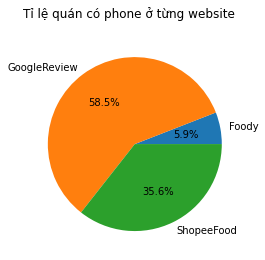

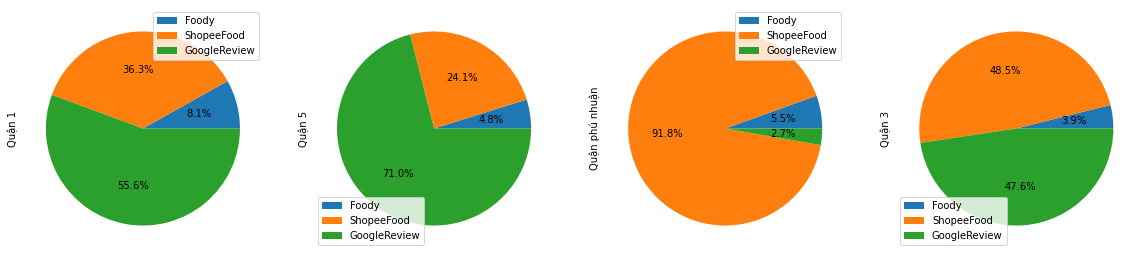

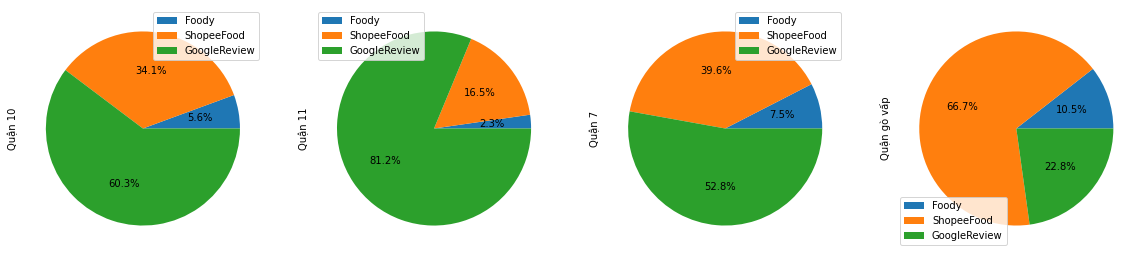

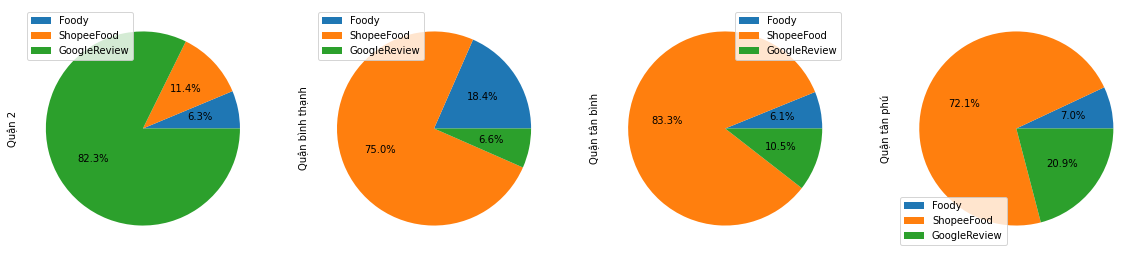

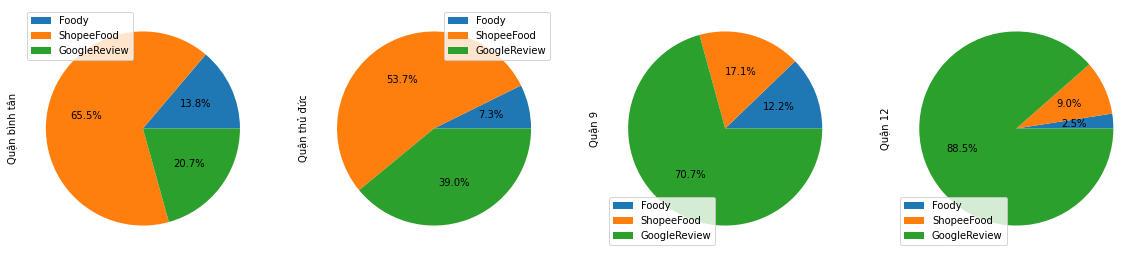

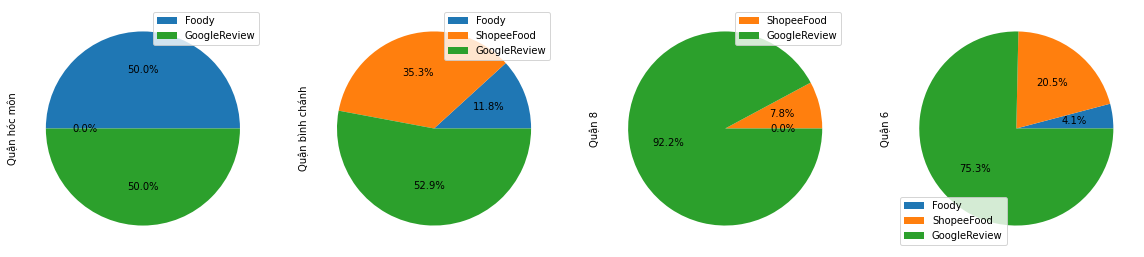

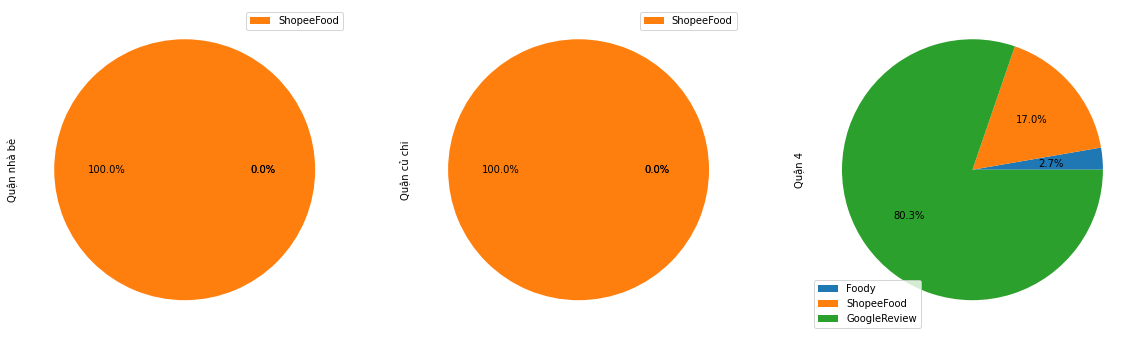

In [248]:
# Tiêu chí: website, phone
# Giải thích: Trên tập dữ liệu, 2 fields có kiểu quan hệ trên thống kê nên dùng pie chart
# Trực quan:

src = DATA[["website","phone"]].groupby("website").count().reset_index()
src.plot.pie(autopct='%1.1f%%',legend=False,y="phone",x="webiste",labels=src["website"])
plt.suptitle("Tỉ lệ quán có phone ở từng website")
plt.ylabel("")
# Ý nghĩa: Thấy được tỉ lệ quán có phone ở từng website

# Mở rộng ra với field quận để khảo sát thêm về tỉ lệ quán có phone

tmp = DATA[["website","district","phone"]].groupby(["website","district"]).count().reset_index()

for i in range(0,len(ListDistrict),4):
    tmp1 = pd.DataFrame({},index=ListWebsite)
    for dis in ListDistrict[i:i+4]:
        tmp2 = tmp[tmp["district"]==dis]
        dt = []
        for web in ListWebsite:
            vl = 0
            if not tmp2[tmp2["website"]==web].empty:
                vl = tmp2[tmp2["website"]==web]["phone"].item()
            dt.append(vl)
        tmp1["Quận %s"%dis] = dt
    tmp1.plot.pie(subplots=True, autopct='%1.1f%%',figsize=(20, 6),labeldistance=None)
    plt.legend(loc=3,labels=ListWebsite);

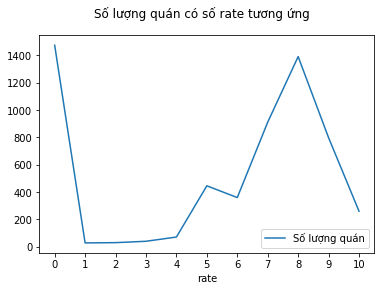

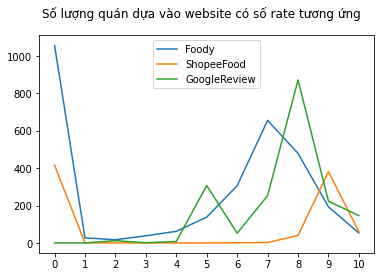

In [275]:
# Tiêu chí: rate, số lượng quán
# Giải thích: để xem có xu hướng nào không
# Trực quan:

# Chia làm 10 đoạn [0,1), [1,2)...
da = []
for i in range(1,12,1):
    da.append(DATA[(DATA["rate"]>=i-1) & (DATA["rate"]<i)].shape[0])
tmp = pd.DataFrame(data={"rate":range(0,11),"Số lượng quán":da})
tmp.plot.line(x='rate',y='Số lượng quán')
plt.xticks(np.arange(0,11,1))
plt.suptitle("Số lượng quán có số rate tương ứng")

# Ý nghĩa: Với rate khác nhau thì số lượng quán sẽ khác nhau, và có xu hướng rate cao thì số lượng quán cũng cao

# Mở rộng ra với field website để xem sự thay đổi ra sao

webstmp = {}
for web in ListWebsite:
    tmp = DATA[DATA["website"]==web]
    da = []
    for i in range(1,12,1):
        da.append(tmp[(tmp["rate"]>=i-1) & (tmp["rate"]<i)].shape[0])
    webstmp[web] = da
tmp = pd.DataFrame(data=webstmp,index=range(0,11))
tmp.plot.line()
plt.xticks(np.arange(0,11,1))
plt.suptitle("Số lượng quán dựa vào website có số rate tương ứng");

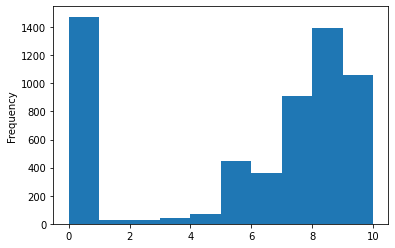

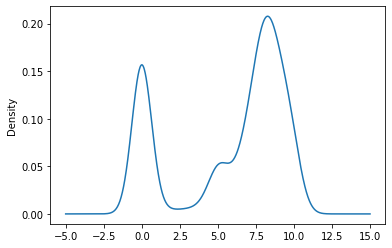

<AxesSubplot:>

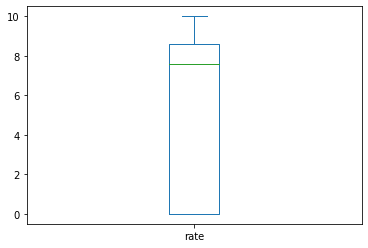

In [283]:
# Tiêu chí: rate
# Giải thích: để tìm ra histogram, lược đồ
# Trực quan:

tmp = DATA["rate"]
tmp.plot.hist()

plt.suptitle("Histogram của rating")

# Ý nghĩa: Nhìn ra được lược độ và biết được sự phân bố

# # Mở rộng ra với field website để xem sự thay đổi ra sao

# webstmp = {}
# for web in ListWebsite:
#     tmp = DATA[DATA["website"]==web]
#     da = []
#     for i in range(1,12,1):
#         da.append(tmp[(tmp["rate"]>=i-1) & (tmp["rate"]<i)].shape[0])
#     webstmp[web] = da
# tmp = pd.DataFrame(data=webstmp,index=range(0,11))
# tmp.plot.line()
# plt.xticks(np.arange(0,11,1))
# plt.suptitle("Số lượng quán dựa vào website có số rate tương ứng");

In [218]:
c=pd.DataFrame({'mass': [0.330, 4.87 , 5.97],
                   'radius': [2439.7, 6051.8, 6378.1]},
                  index=['Mercury', 'Venus', 'Earth'])
c[c["mass"]==0.330]["radius"].item()

2439.7

#### Hiếu section

In [ ]:
# code here

#### Hằng section

In [ ]:
# code here